<a href="https://colab.research.google.com/github/sgr1118/GD-NLP/blob/main/%5BGD2_Use_SentencePiece%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2-5. 프로젝트: SentencePiece 사용하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

[**네이버 영화리뷰 감정 분석 태스크**](https://github.com/e9t/nsmc/)가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요.

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [2]:
# 필요한 라이브러리 및 데이터 불러오기
import pandas as pd
import konlpy
import re
import matplotlib.pyplot as plt
import urllib.request
import numpy as np

%matplotlib inline

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
df = pd.read_table('ratings.txt')
df.head()

ModuleNotFoundError: ignored

In [ ]:
df.loc[143498]

id                                                    7029559
document    후................................................
label                                                       0
Name: 143498, dtype: object

In [ ]:
df.sample(10)

,id,document,label
173727,8309267,안봐도 내용뻔히보이는막장드라마~!! 이드라마보다가 며칠안보고있는데~은희수 OOOO~...,0
52978,8054922,"개인적으로 손빈이라는 인물을 존경하기도 하고, 배우들이 인물들을 잘 표현해줘서 재밌...",1
149149,7412584,이거 왜이러케 평점이 높냐 말도안되게 짜 맞췄던데,0
86779,5427082,어느 OO들이 이거 보면서 초딩만화라고 욕하냐 OO들이,1
74084,9859888,다른 사람으로 살고 싶다는 생각을 저도 참 많이 했어서 그런지 간만에 집중해서 본 ...,1
94779,10178774,마지막에 성모 마리아를 찾아내는 장면은 정말..,1
66457,9692838,영화 잘 만들었네요...,1
34911,9464344,끝난지 오래 되었지만..아직까지 헤어나오지 못한 1인..,1
176125,8512096,83분동안 개콘 홍보영화 봤다 그리고 김원효 너는 만화 더빙 진짜 그만둬라 벌써 3...,0
113340,6736228,댓글 두번째인가.. 이 영화 전쟁씬 대박임 꼭 보셈 무슨 지적장애아들 모아놓고 전쟁...,0


# 전처리 수행

1. 결측치, 중복값 확인 후 제거

2. 정규표현식을 사용하여 문장 데이터 전처리

3. df의 ducument column의 데이터 길이 분포 확인
 - 너무 짧은 리뷰는 추출 후 삭제

1. 결측치, 중복값 확인 후 제거

In [ ]:
# 데이터 결측치 확인
print(df.isnull().sum())

id          0
document    8
label       0
dtype: int64


In [ ]:
# 데이터 중복값 확인
print(df.duplicated(subset='document', keep='first').sum())
# keep = 'first'는 중복이 있으면 처음과 마지막 값 중 처음값을 남긴다.

5456


In [ ]:
# 결측치, 중복값 제거
def preprocessing(df):
  df.drop_duplicates(subset=['document'], inplace=True)
  df = df.dropna(how = 'any', inplace=True)

preprocessing(df)

In [ ]:
# 전처리 결과 확인
print(df.isnull().sum())
print(df.duplicated(subset='document', keep='first').sum())
print(len(df))

id          0
document    0
label       0
dtype: int64
0
194543


2. 정규표현식을 사용하여 문장 데이터 전처리

In [ ]:
# df로부터 document추출
df_review = df['document']

In [ ]:
def preprocess_sentence(sentence):
  sentence = sentence.str.lower() # 텍스트 소문자화
  sentence = sentence.str.replace(pat=r'[ㄱ-ㅎㅏ-ㅣa-z?.!,¿]{1}', repl=' ', regex=True) # 연속적인 구두점, 자음, 알파벳 지우기
  sentence = sentence.str.replace(pat= r'([?.!,¿])', repl=r' \1', regex=True) #  구두점 분리
  sentence = sentence.str.replace(pat=r'[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-z!.?]+', repl =" ",regex=True) # 0-9ㄱ-ㅎㅏ-ㅣ가-힣a-z!.?가 아닌 모든 문자를 하나의 공백으로 바꿉니다
  
  return sentence

In [ ]:
df['document'] = preprocess_sentence(df_review)

In [ ]:
# 결과확인
df.sample(10)

,id,document,label
41957,9082146,처음엔 못 미덥던 사람들이 신조를 잇고 철옹성같던 사람들은 약해지네요,1
119112,8700636,내용이 너무 지루해요 7살아듵과 봤는데 재미없다고 하네요,0
49565,9087505,캐러비안의 해적을 중심으로 모든 해적물은 비교받게된다,1
51301,1999985,앤디가르시아의 눈물 맥라이언의 사랑스러움,1
190056,6845230,멍청이들 땜에 짜증나서 스킵해서 봤다,0
15611,7868198,,1
192198,8212516,별로 최악의 영화다 보지 말길,0
100482,2417339,새로운 척 하지만 식상해 표피만 있는 겉멋용 영화 이젠 정말 싫다,0
101679,7617855,허접,0
122359,3246673,영화는 정말 짧지만 지루하기만 했던 시간,0


3. df의 ducument column의 데이터 길이 분포 확인
 - 너무 짧은 리뷰는 추출 후 삭제

In [ ]:
df_review = df['document']

문장의 최단 길이: 1
문장의 최장 길이: 140
문장의 평균 길이: 33


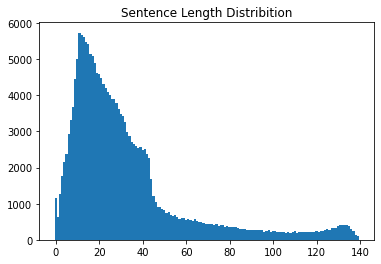

In [ ]:
min_len = 999
max_len = 0
sum_len = 0

for sen in df_review:
  length = len(sen)
  if min_len > length: min_len = length
  if max_len < length: max_len = length
  sum_len += length

print('문장의 최단 길이:', min_len)
print('문장의 최장 길이:', max_len)
print('문장의 평균 길이:', sum_len // len(df_review))

sentence_length = np.zeros((max_len), dtype = np.int64)

for sen in df_review:
  sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width = 1.0)
plt.title('Sentence Length Distribition')
plt.show()

# 문장 분포에서 길이가 1이지만 1000개의 row가 있는것이 확인되었다.
# 문장을 확이해보는것이 필요하다.

In [ ]:
# 길이가 1인 데이터 출력
df[df['document'].str.len() == 1]
# 공백이 문장으로 남아있는 현상이 발생하였다.
# 전처리 후 생긴 문제인거같다.

,id,document,label
8,7477618,굿,1
106,5458245,핡,1
111,6906147,,1
190,7059515,,1
203,10216462,,1
...,...,...,...
199271,4852134,,0
199297,9233162,,0
199321,4602734,2,0
199581,2259844,,0


In [ ]:
df['document'].iloc[111]
# 특정행을 출력해보니 ' '인 것을 확인하였다.
# 이런 데이터는 전부 지워주도록 해야겠다.

' '

In [ ]:
# 삭제할 조건 지정 후 삭제
index = df[df['document'] == ' '].index
df.drop(index, inplace = True)

In [ ]:
df_review = df['document']

문장의 최단 길이: 1
문장의 최장 길이: 140
문장의 평균 길이: 33


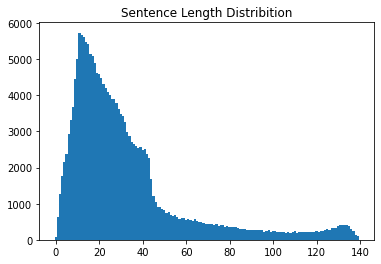

In [ ]:
min_len = 999
max_len = 0
sum_len = 0

for sen in df_review:
  length = len(sen)
  if min_len > length: min_len = length
  if max_len < length: max_len = length
  sum_len += length

print('문장의 최단 길이:', min_len)
print('문장의 최장 길이:', max_len)
print('문장의 평균 길이:', sum_len // len(df))

sentence_length = np.zeros((max_len), dtype = np.int64)

for sen in df_review:
  sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width = 1.0)
plt.title('Sentence Length Distribition')
plt.show()

# 문장 분포에서 길이가 1이지만 1000개의 row가 있는것이 확인되었다.
# 문장을 확이해보는것이 필요하다.

In [ ]:
# 샘플 길이에따른 데이터 분포 확인
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
      cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
below_threshold_len(33, df_review) # 평균
below_threshold_len(150, df_review) # 최대
below_threshold_len(40, df_review) # 임의 지정1
below_threshold_len(60, df_review) # 임의 지정2
below_threshold_len(80, df_review) # 임의 지정2

전체 샘플 중 길이가 33 이하인 샘플의 비율: 0.6526510022018462
전체 샘플 중 길이가 150 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.7503127035157179
전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.8691658827542719
전체 샘플 중 길이가 80 이하인 샘플의 비율: 0.9168415394316549


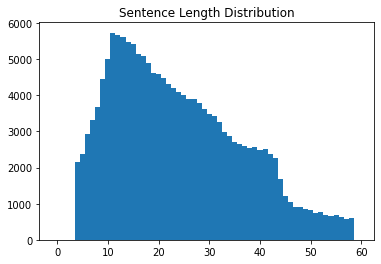

In [ ]:
# 일정 길이의 데이터 제외시키기
# 문장길이는 최대 60, 최소 5로 지정한다.

max_len = 60
min_len = 5

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in df_review if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype = np.int64)

for sen in filtered_corpus:
  sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# Step 1. SentencePiece 설치하기

SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 아래 링크의 페이지에서 상세한 내용을 파악할 수 있습니다.

[google/sentencepiece](https://github.com/google/sentencepiece)

위 페이지의 서두에서도 언급하고 있듯, SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model들이 거의 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준의 역할을 하고 있습니다.

다음과 같이 설치를 진행합니다. SentencePiece는 python에서 쓰라고 만들어진 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있습니다.

In [ ]:
import os, sys

my_path = '/content/drive'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/MyDrive/Colab Notebooks/sentencepiece', my_path)
sys.path.insert(0, my_path)


In [ ]:
!pip install --target=$my_path sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 3.7 MB/s 


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.0 MB/s 


Step 2. SentencePiece 모델 학습

[SentencePiece 보충 학습](https://paul-hyun.github.io/vocab-with-sentencepiece/)

- input: 입력 corpus
- prefix: 저장할 모델 이름
- vocab_size: vocab 개수 (기본 8,000에 스페셜 토큰 7개를 더해서 8,007개)
- max_sentence_length: 문장의 최대 길이
- pad_id, pad_piece: pad token id, 값
- unk_id, unk_piece: unknown token id, 값
- bos_id, bos_piece: begin of sentence token id, 값
- eos_id, eos_piece: end of sequence token id, 값
- user_defined_symbols: 사용자 정의 토큰


In [ ]:
import sentencepiece as spm

temp_file = '/content/drive/MyDrive/Aiffel/GD_project/GD2_file/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
  for row in filtered_corpus: # 이전 스텝에서 정제했던 corpus를 활용합니다.
    f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size))

# 위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. 
# --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

In [ ]:
!ls -l korean_spm*

-rw-r--r-- 1 root root 378855 Sep 23 03:29 korean_spm.model
-rw-r--r-- 1 root root 148313 Sep 23 03:29 korean_spm.vocab


In [ ]:
# SentencePiece 모델 테스트하기
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',-1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1377, 7, 437, 13, 1274, 7, 164, 11, 0]
['▁아', '버', '지', '가', '방', '에', '들', '어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


# Step 3. Tokenizer 함수 작성

우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize()
함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하습니다.

1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2. 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?



In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [ ]:
import tensorflow as tf

In [ ]:
#sp_tokenize(s, corpus) 사용예제

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 440 2821   10 1005 2421    0    0    0    0    0    0]
 [1145 1858    3    0  532    7    3   12 7901  650    0]]


 # Step4 모델 생성

In [ ]:
# 텐서와 단어 사전 나누기 
tensor, word_index, index_word = sp_tokenize(s, df['document'])

In [ ]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(df['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [ ]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

123823 30956 38695
123823 30956 38695


In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow import keras
from tensorflow.keras.initializers import Constant

vocab_size = vocab_size   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 

model_BILSTM = tf.keras.Sequential()
model_BILSTM.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim))
model_BILSTM.add(keras.layers.Bidirectional(LSTM(64)))
model_BILSTM.add(keras.layers.Dense(1, activation='sigmoid'))

model_BILSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          256000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 305,793
Trainable params: 305,793
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습 진행하기

model_BILSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20
# 앞선 모델들이 낮은 에포크에서 이미 validation loss가 증가하는 현상을 보여 에포크를 10으로 낮춰서 학습해보기로 결정하였다.

history5 = model_BILSTM.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
242/242 [==============================] - 18s 35ms/step - loss: 0.4762 - accuracy: 0.7724 - val_loss: 0.3687 - val_accuracy: 0.8441
Epoch 2/20
242/242 [==============================] - 7s 31ms/step - loss: 0.3326 - accuracy: 0.8598 - val_loss: 0.3494 - val_accuracy: 0.8495
Epoch 3/20
242/242 [==============================] - 7s 31ms/step - loss: 0.3089 - accuracy: 0.8686 - val_loss: 0.3447 - val_accuracy: 0.8513
Epoch 4/20
242/242 [==============================] - 7s 31ms/step - loss: 0.2932 - accuracy: 0.8759 - val_loss: 0.3440 - val_accuracy: 0.8522
Epoch 5/20
242/242 [==============================] - 7s 31ms/step - loss: 0.2782 - accuracy: 0.8816 - val_loss: 0.3459 - val_accuracy: 0.8508
Epoch 6/20
242/242 [==============================] - 7s 31ms/step - loss: 0.2613 - accuracy: 0.8891 - val_loss: 0.3557 - val_accuracy: 0.8496
Epoch 7/20
242/242 [==============================] - 7s 31ms/step - loss: 0.2460 - accuracy: 0.8956 - val_loss: 0.3606 - val_accuracy: 0.849

In [ ]:
# 그래프 dict_keys

history_dict5 = history5.history
print(history_dict5.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


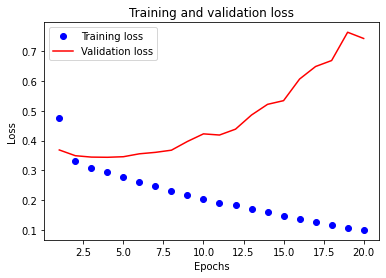

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict5['accuracy']
val_acc = history_dict5['val_accuracy']
loss = history_dict5['loss']
val_loss = history_dict5['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

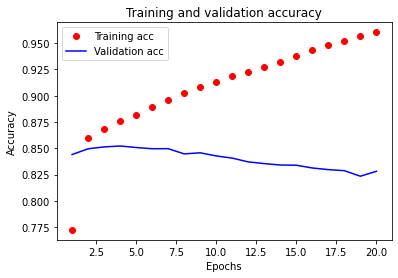

In [ ]:
plt.clf()   # 그림을 초기화합니다
# "ro"는 "빨간색 점"입니다
plt.plot(epochs, acc, 'ro', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model_BILSTM.evaluate(x_test,  y_test, verbose=2)
print('loss : {:.4f}'.format(results[0]), 'accuracy : {:.4f}'.format(results[1]))

968/968 - 6s - loss: 0.7314 - accuracy: 0.8296 - 6s/epoch - 6ms/step
loss : 0.7314 accuracy : 0.8296


디른 토크나이저 사용해보기

더 높은 정확도를 위하여 옳바르지 못한 맞춤법이 많은 리뷰데이터에는 KOMORAN을 사용하여 결과를 비교해보기로 한다.

python에서 KOMORAN을 사용할 때 발생할 수 있는 문제 해결

[KOMORAN 오류 해결](https://velog.io/@yerimstar/Komoran-error-java.lang.NullPointerException)

대부분 데이터에 '\n'가 있어서 발생하는 문제이다.
따라서, ''로 치환해준 뒤, 형태소분석을 진행해야 한다.


In [53]:
# 필요한 라이브러리 및 데이터 불러오기
import pandas as pd
import konlpy
import re
import matplotlib.pyplot as plt
import urllib.request
import numpy as np

%matplotlib inline

train_data = pd.read_table('/content/drive/MyDrive/Aiffel/GD_project/GD2_file/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Aiffel/GD_project/GD2_file/ratings_test.txt')

In [54]:
train_review = train_data['document']
test_review = test_data['document']

In [55]:
# 정규표현식을 사용한 전처리 적용

def preprocess_sentence(sentence):
  sentence = sentence.str.lower() # 텍스트 소문자화
  sentence = sentence.str.replace(pat=r'[ㄱ-ㅎㅏ-ㅣa-z?.!,¿]{1}', repl='', regex=True) # 연속적인 구두점, 자음, 알파벳 지우기
  sentence = sentence.str.replace(pat= r'([?.!,¿])', repl=r' \1', regex=True) #  구두점 분리
  sentence = sentence.str.replace(pat=r'[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-z!.?]+', repl ='',regex=True) # 0-9ㄱ-ㅎㅏ-ㅣ가-힣a-z!.?가 아닌 모든 문자를 하나의 공백으로 바꿉니다
  
  return sentence

In [56]:
# 전처리 적용
train_data['document'] = preprocess_sentence(train_review)
test_data['document'] = preprocess_sentence(test_review)

In [57]:
# koroman 오류 방지
train_data = train_data.replace('.', '').replace(',','').replace("'","").replace('·', ' ').replace('=','').replace('\n','').replace('\t','').replace('\r','')
test_data = test_data.replace('.', '').replace(',','').replace("'","").replace('·', ' ').replace('=','').replace('\n','').replace('\t','').replace('\r','')

In [59]:
from konlpy.tag import Komoran
from collections import Counter
tokenizer = Komoran()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] 
num_words = 10000

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
  
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [60]:
# 텍스트 확인
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[0])
print(word_to_index['<PAD>'])

<PAD>
0


In [61]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
  return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
  return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
  return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
  return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [62]:
# 3. 모델 구성을 위한 데이터 분석 및 가공
total_data_text = list(X_train) + list(X_test)
# txt데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# 적절한 최대 문장 길이는 39이다.

문장길이 평균 :  13.783237844940867
문장길이 최대 :  105
문장길이 표준편차 :  12.63162290510425
pad_sequences maxlen :  39
전체 문장의 0.9416241787122208%가 maxlen 설정값 이내에 포함됩다. 


In [63]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더빙 진짜 짜증 나 네 요 목소리
라벨:  0


In [64]:
# pad_sequences 을 활용한 패딩 추가
# padding은 pre로 설정을 해보았다. 이유는 RNN이 학습을 할 때 순차적으로 데이터가 입력이된다.
# 마지막 입력이 무의미한 값으로 입력되는 post보다 pre가 더 좋은 성능을 낼 것으로 생각한다.
import tensorflow as tf
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape, X_test.shape)

(142184, 39) (48066, 39)


In [65]:
#  validation set 구성
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(92184, 39)
(92184,)


In [67]:
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow import keras
from tensorflow.keras.initializers import Constant

vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 

model_BILSTM = tf.keras.Sequential()
model_BILSTM.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim))
model_BILSTM.add(keras.layers.Bidirectional(LSTM(64)))
model_BILSTM.add(keras.layers.Dense(1, activation='sigmoid'))

model_BILSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 369,793
Trainable params: 369,793
Non-trainable params: 0
_________________________________________________________________


In [73]:
# 학습 진행하기

model_BILSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history = model_BILSTM.fit(partial_X_train, 
                    partial_y_train,
                    epochs = epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
181/181 [==============================] - 11s 19ms/step - loss: 0.1734 - accuracy: 0.9099 - val_loss: 0.7613 - val_accuracy: 0.7860
Epoch 2/20
181/181 [==============================] - 2s 13ms/step - loss: 0.1627 - accuracy: 0.9135 - val_loss: 0.7994 - val_accuracy: 0.7760
Epoch 3/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1688 - accuracy: 0.9129 - val_loss: 0.8539 - val_accuracy: 0.7829
Epoch 4/20
181/181 [==============================] - 2s 14ms/step - loss: 0.1520 - accuracy: 0.9180 - val_loss: 0.8880 - val_accuracy: 0.7770
Epoch 5/20
181/181 [==============================] - 2s 13ms/step - loss: 0.1480 - accuracy: 0.9196 - val_loss: 0.9159 - val_accuracy: 0.7752
Epoch 6/20
181/181 [==============================] - 2s 13ms/step - loss: 0.1441 - accuracy: 0.9205 - val_loss: 1.0047 - val_accuracy: 0.7763
Epoch 7/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.9221 - val_loss: 0.9489 - val_accuracy: 0.778

In [74]:
# 그래프 dict_keys

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


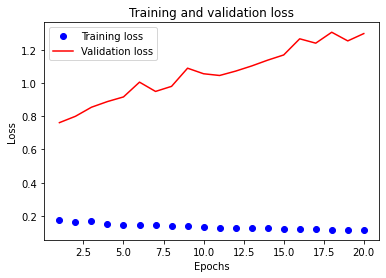

In [75]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

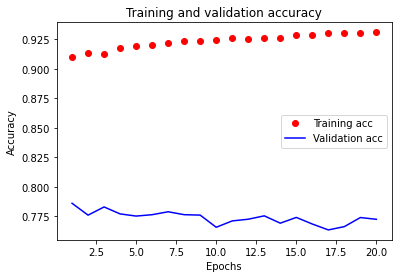

In [76]:
plt.clf()   # 그림을 초기화합니다
# "ro"는 "빨간색 점"입니다
plt.plot(epochs, acc, 'ro', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [78]:
results = model_BILSTM.evaluate(X_test,  y_test, verbose=2)
print('loss : {:.4f}'.format(results[0]), 'accuracy : {:.4f}'.format(results[1]))

1503/1503 - 5s - loss: 1.2872 - accuracy: 0.7706 - 5s/epoch - 3ms/step
loss : 1.2872 accuracy : 0.7706


In [79]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 lstm_1 (LSTM)               (None, 12)                1392      
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [80]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history2 = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
181/181 [==============================] - 5s 9ms/step - loss: 0.5579 - accuracy: 0.7241 - val_loss: 0.4268 - val_accuracy: 0.7930
Epoch 2/20
181/181 [==============================] - 1s 7ms/step - loss: 0.4008 - accuracy: 0.8055 - val_loss: 0.4042 - val_accuracy: 0.8034
Epoch 3/20
181/181 [==============================] - 1s 7ms/step - loss: 0.3744 - accuracy: 0.8196 - val_loss: 0.4019 - val_accuracy: 0.8045
Epoch 4/20
181/181 [==============================] - 1s 7ms/step - loss: 0.3603 - accuracy: 0.8270 - val_loss: 0.4019 - val_accuracy: 0.8055
Epoch 5/20
181/181 [==============================] - 1s 7ms/step - loss: 0.3492 - accuracy: 0.8324 - val_loss: 0.4066 - val_accuracy: 0.8041
Epoch 6/20
181/181 [==============================] - 1s 7ms/step - loss: 0.3358 - accuracy: 0.8386 - val_loss: 0.4121 - val_accuracy: 0.8037
Epoch 7/20
181/181 [==============================] - 1s 7ms/step - loss: 0.3230 - accuracy: 0.8451 - val_loss: 0.4239 - val_accuracy: 0.7975
Epoch 

In [82]:
# 그래프 dict_keys

history_dict2 = history2.history
print(history_dict2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


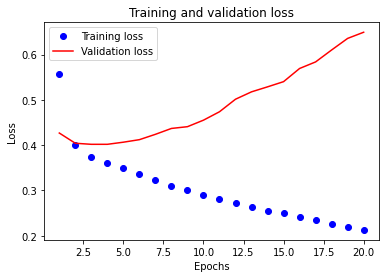

In [84]:
import matplotlib.pyplot as plt

acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

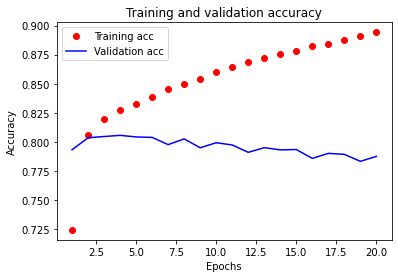

In [85]:
plt.clf()   # 그림을 초기화합니다
# "ro"는 "빨간색 점"입니다
plt.plot(epochs, acc, 'ro', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [83]:
results = model_rnn.evaluate(X_test,  y_test, verbose=2)
print('loss : {:.4f}'.format(results[0]), 'accuracy : {:.4f}'.format(results[1]))

1503/1503 - 3s - loss: 0.6479 - accuracy: 0.7839 - 3s/epoch - 2ms/step
loss : 0.6479 accuracy : 0.7839


# 회고

1. 이번 프로젝트에서 어려웠던 점
 
 (1) 리뷰 데이터의 맞춤법이 좋지 않기 때문에 최대한 문장을 정제하려는게 힘들었습니다. 사람들의 감정이 텍스트에 담길 때 연속적인 자음이나 구두점이 활용되다보니 그런 내용을 제거하였습니다. 

  (2) 다른 한글 형태소 분석기인 Komoran을 사용하려 할 때 'java.lang.NullPointerException'라는 오류가 발생하여 문제 해결이 쉽지 않았습니다. 다행히 오류는 해결하여 분석에 차질없이 사용하였습니다. 다만 성능은 SentencePiece를 따라가기 쉽지 않았습니다.
 

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

(1) 왜 Komoran은 별도의 조치가 필요하였을까?

- 예전에 영화 리뷰 데이터에서 mecab을 사용할 때는 이런 조치를 한 적이 없어도 정상적으로 구동이 잘 되었습니다. 이번에는 '\n', '\t' 등 제거가 필요하였습니다.





참조

(1) [KOMORAN 오류 해결](https://velog.io/@yerimstar/Komoran-error-java.lang.NullPointerException)

